# William Etzler ECON 4984 Assignment 1

## Problem 1 a

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math

In [139]:
from scipy.integrate import quad
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

In [140]:
np.random.seed(64)

In [141]:
file_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\kidney.txt'
kidney = pd.read_csv(file_path, delimiter=' ')
kidney.head()

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


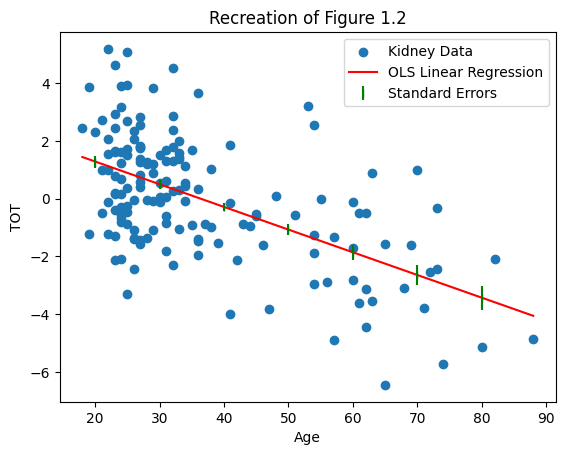

In [142]:
X = sm.add_constant(kidney['age'])
x_coords = [20, 30, 40, 50, 60, 70, 80]

model1 = sm.OLS(kidney['tot'], X).fit()
x_pred = sm.add_constant(x_coords)
y1_pred = model1.predict(x_pred)
std_errors = model1.get_prediction(x_pred).se_mean

plt.scatter(kidney['age'], kidney['tot'], label='Kidney Data')
plt.plot(kidney['age'], model1.predict(X), color= 'red', label='OLS Linear Regression')
plt.errorbar(x_coords, y1_pred, yerr=std_errors, fmt='|', color='green', label='Standard Errors')

plt.xlabel('Age')
plt.ylabel('TOT')
plt.title('Recreation of Figure 1.2')
plt.legend()
plt.show()

### Setup variables for cubic regression 

In [143]:
ages_to_predict = np.array([20, 30, 40, 50, 60, 70, 80])
degree = 3
kidx = kidney['age'].values.reshape(-1, 1) 
kidy = kidney['tot']

poly = PolynomialFeatures(degree=degree)
x_poly = poly.fit_transform(kidx)

model2 = LinearRegression()
model2.fit(x_poly, kidy)

y2_pred = model2.predict(x_poly)

### Defining standard error method using residuals and properly aligning variables

In [144]:
def calculate_standard_error(x_design, y_true, y_pred, poly_transformed_ages):

    n_sample = x_design.shape[0]
    n_predictors = x_design.shape[1]

    residuals = y_true - y_pred
    residual_variance = np.sum(residuals ** 2) / (n_sample - n_predictors)

    hat_matrix = np.dot(np.dot(x_design, np.linalg.pinv(np.dot(x_design.T, x_design))), x_design.T)
    leverage = np.diag(hat_matrix)

    poly_ages = poly.transform(poly_transformed_ages)
    leverage_ages = np.diag(np.dot(poly_ages, np.dot(np.linalg.pinv(np.dot(x_design.T, x_design)), poly_ages.T)))
    std_error = np.sqrt(residual_variance * (1 + leverage_ages))

    return std_error

### Finish cubic regression, assign standard error,  and plot

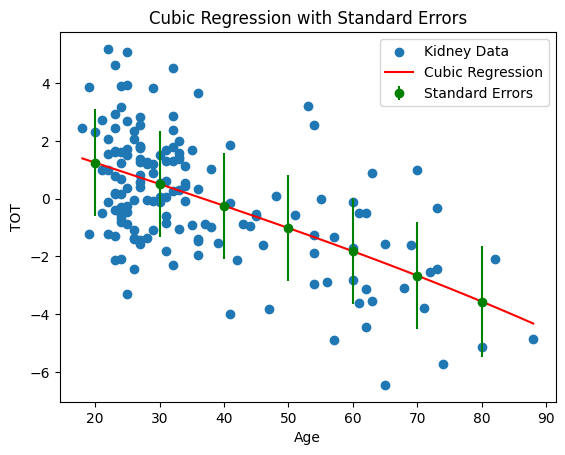

In [145]:
# Predict the values using the model for these ages
ages_poly = poly.transform(ages_to_predict.reshape(-1, 1))
cubic_estimates = model2.predict(ages_poly)

# Calculate the standard errors
cubic_stderr = calculate_standard_error(x_poly, kidy, y2_pred, ages_to_predict.reshape(-1, 1))

# Plot the model and the standard errors
tempx = np.linspace(kidx.min(), kidx.max(), 100).reshape(-1, 1)
tempx_poly = poly.transform(tempx)
cubic_ypred = model2.predict(tempx_poly)

plt.scatter(kidx, kidy, label='Kidney Data')
plt.plot(tempx, cubic_ypred, color='red', label='Cubic Regression')
plt.errorbar(ages_to_predict, cubic_estimates, yerr=cubic_stderr, fmt='o', color='green', label='Standard Errors')

plt.xlabel('Age')
plt.ylabel('TOT')
plt.title('Cubic Regression with Standard Errors')
plt.legend()
plt.show()

## Problem 1 b

In [146]:
cubic_results = pd.DataFrame({
    'age': ages_to_predict,
    'linear regression' : y1_pred,
    'std error' : std_errors,
    'cubic estimate': cubic_estimates,
    'cubic std error': cubic_stderr
}).round(2)
cubic_results = pd.DataFrame(cubic_results.set_index('age')).T
cubic_results

age,20,30,40,50,60,70,80
linear regression,1.29,0.50,-0.28,-1.07,-1.86,-2.64,-3.43
std error,0.21,0.15,0.15,0.19,0.26,0.34,0.42
cubic estimate,1.25,0.51,-0.24,-1.01,-1.82,-2.66,-3.56
cubic std error,1.85,1.82,1.83,1.83,1.84,1.85,1.93


The estimates between the linear and cubic regression models are quite close across ages. As they are not substantially different, it could indicate the additional complexity of the cubic model does not meaningfully change the predictions.

The standard errors for the cubic regression are much higher at every age. This likely means the cubic model is capturing more noise, giving a poor generalization of the data through over fitting. It could also indicate the cubic model is more sensitive to the data and has less confidence in its predictions for the same number of observations as the linear model. 

## Problem 2 

In [147]:
gfr_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\gfr.txt'
gfr = pd.read_csv(gfr_path, delimiter=' ', header=None)
gfr.tail()

,0
206,28
207,33
208,35
209,48
210,31


### Recreate Table 2.1 data, define bootstrap method for trimmed means and standard errors, then assign to data and print new table

In [148]:
gfr_series = gfr.iloc[:, 0]
trim_proportions = [0.1, 0.2, 0.3, 0.4]

# Recreate Table 2.1
def bootstrap_statistic(data, func, n_bootstrap=1000):
    bootstrap_samples = np.random.choice(data, (n_bootstrap, len(data)), replace=True)
    bootstrap_statistics = np.array([func(sample) for sample in bootstrap_samples])
    estimate = func(data)
    std_error = bootstrap_statistics.std(ddof=1)
    return estimate, std_error

normal_mean, normal_std_error = bootstrap_statistic(gfr_series, np.mean)
winsorized_mean, winsorized_std_error = bootstrap_statistic(
    gfr_series, lambda x: stats.mstats.winsorize(x, limits=0.25).mean())
median, median_std_error = bootstrap_statistic(gfr_series, np.median)

# Define bootstrap method
def bootstrap_trimmed_mean(data, trim_proportion, n_bootstrap=1000):
    trimmed_mean = stats.trim_mean(data, proportiontocut=trim_proportion)
    
    bootstrap_means = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_trim_mean = stats.trim_mean(bootstrap_sample, proportiontocut=trim_proportion)
        bootstrap_means.append(bootstrap_trim_mean)
    
    bootstrap_std_error = np.std(bootstrap_means, ddof=1)
    
    return trimmed_mean, bootstrap_std_error

# Assign to data
results = {}
for trim_prop in trim_proportions:
    results[f"{int(trim_prop * 100)}% Trimmed Mean"] = bootstrap_trimmed_mean(gfr_series, trim_prop)
results['Normal Mean'] = (normal_mean, normal_std_error)
results['25% Winsorized Mean'] = (winsorized_mean, winsorized_std_error)
results['Median'] = (median, median_std_error)

# Print table
q2_results = pd.DataFrame(results, index=["Estimate", "Standard Error"]).T.round(2)
new_order = ['Normal Mean', '25% Winsorized Mean', 'Median',
             '10% Trimmed Mean', '20% Trimmed Mean', '30% Trimmed Mean', '40% Trimmed Mean']
q2_results = q2_results.loc[new_order]
q2_results

,Estimate,Standard Error
Normal Mean,54.27,0.97
25% Winsorized Mean,52.81,0.93
Median,52.00,0.86
10% Trimmed Mean,53.01,0.86
20% Trimmed Mean,52.76,0.81
30% Trimmed Mean,52.54,0.74
40% Trimmed Mean,52.26,0.79


Recreated Table 2.1 results vary due to incongruent seeds for the random operations used in bootstrap

## Problem 3

In [149]:
scores_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\student_score.txt'
scores = pd.read_csv(scores_path, delimiter=' ')
scores.tail()
len(scores)

22

### Code directly from chapter 3 examples notebook

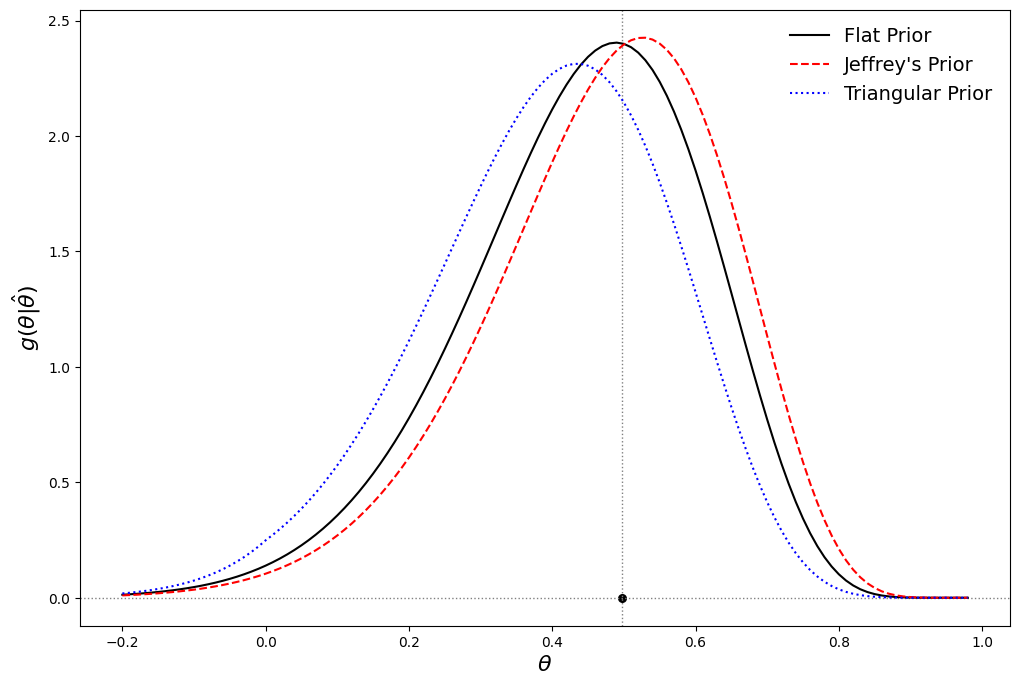

In [150]:
x1 = scores.mech
x2 = scores.vecs

pi = math.pi
n = 22
theta_hat = np.corrcoef(x1,x2)[1,0]

def f_cond(theta_hat,theta):
    int_out = (n-2)*(1-theta**2)**((n-1)/2)*(1-theta_hat**2)**((n-4)/2)/pi
    intgral, err = quad(lambda w: 1/((math.cosh(w)-theta*theta_hat))**(n-1), 0.0, 10)
    return int_out*intgral

g_flat = 1/2
g_jeff = lambda theta: 1/(1-theta**2)
g_trig = lambda theta: 1-abs(theta)

f_thetahat_flat, err1 = quad(lambda theta: f_cond(theta_hat,theta)*g_flat, -1, 1)
f_thetahat_jeff, err2 = quad(lambda theta: f_cond(theta_hat,theta)*g_jeff(theta), -1, 1)
f_thetahat_trig, err3 = quad(lambda theta: f_cond(theta_hat,theta)*g_trig(theta), -1, 1)

post_flat = lambda theta: g_flat*f_cond(theta_hat,theta)/f_thetahat_flat
post_jeff = lambda theta: g_jeff(theta)*f_cond(theta_hat,theta)/f_thetahat_jeff
post_trig = lambda theta: g_trig(theta)*f_cond(theta_hat,theta)/f_thetahat_trig

x_theta = np.arange(-0.2, 0.99, 0.01) 
y_flat = np.zeros(len(x_theta))
y_jeff = np.zeros(len(x_theta))
y_trig = np.zeros(len(x_theta))
for i in range(len(x_theta)):
    y_flat[i] = post_flat(x_theta[i])
    y_jeff[i] = post_jeff(x_theta[i])
    y_trig[i] = post_trig(x_theta[i])
    
fig, ax = plt.subplots(figsize=(12, 8))

ax.axhline(0, c="gray", linestyle=":", linewidth=1)
ax.axvline(theta_hat, c="gray", linestyle=":", linewidth=1)

ax.plot(x_theta, y_flat, "k", label= "Flat Prior")
ax.plot(x_theta, y_jeff, "r--", label= "Jeffrey's Prior")
ax.plot(x_theta, y_trig, "b:", label= "Triangular Prior")
ax.scatter([theta_hat], [0], c="k", s=30)

ax.set_xlabel(r"$\theta$", size=16)
ax.set_ylabel(r"$g(\theta|\hat{\theta})$", size=16);
ax.legend(loc='upper right', frameon=False, fontsize=14)

plt.show()

## Problem 4 a

### Verification of MLE for Normal Distribution

Given a set of observations $X_i$, the likelihood function for a normal distribution is:

$$ L(\theta, \sigma | X_i) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X_i - \theta)^2}{2\sigma^2}\right) $$

To find the MLEs, take the logarithm of the likelihood (log-likelihood), which turns the product into a sum:

$$ \log L(\theta, \sigma | X_i) = \sum_{i=1}^{n} \log\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \sum_{i=1}^{n}\frac{(X_i - \theta)^2}{2\sigma^2} $$

Taking the derivative of the log-likelihood with respect to $\theta$ and setting it to zero gives us the MLE for $\theta$:

$$ \frac{\partial}{\partial \theta} \log L(\theta, \sigma | X_i) = \sum_{i=1}^{n} \frac{(X_i - \theta)}{\sigma^2} = 0 $$

Solving for $\theta$:

$$ \hat{\theta} = \frac{1}{n}\sum_{i=1}^{n} X_i = \bar{X} $$

Taking the derivative of the log-likelihood with respect to $\sigma$ and setting it to zero gives us the MLE for $\sigma$:

$$ \frac{\partial}{\partial \sigma} \log L(\theta, \sigma | X_i) = \sum_{i=1}^{n} \left(-\frac{1}{\sigma} + \frac{(X_i - \theta)^2}{\sigma^3}\right) = 0 $$

Solving for $\sigma$:

$$ \hat{\sigma} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (X_i - \hat{\theta})^2} $$

Therefore, the MLEs for the mean and standard deviation are:

$$ (\hat{\theta}, \hat{\sigma}) = \left( \bar{X}, \sqrt{\frac{1}{n}\sum_{i=1}^{n} (X_i - \bar{X})^2} \right) $$

## Problem 4 b

The generally preferred formula uses the Bessel correction which uses n - 1 instead of n when calculating sigma hat. It is used to provide an unbiased estimate of the variance as using just n could underestimate the population variance when sample size is small. For maximum likelihood estimates, n is used because MLEs are about finding the parameter values that make the observed data most likely, without bias correction. However, for unbiased estimates of population parameters, n−1 is used.

## Problem 5 a

In [151]:
prost_path = r'C:\Users\wetzl\Desktop\Python\SSEcon\Data\prostz.txt'
prost = pd.read_csv(prost_path, delimiter=' ')
prost.tail()

,1.47236666651029
6027,0.287357
6028,-0.777423
6029,-1.183667
6030,0.103544
6031,-0.909193


Thought about recreating histogram from book, so I imported the data even though it isn't needed. Ended up not recreating histogram. 

### Create simulation based off provided parameters

In [152]:
n_simulations = 200
n_samples = 500

d_values = np.zeros(n_simulations)

for sim in range(n_simulations):
    means = 3 * np.arange(1, n_samples + 1) / 500
    samples = np.random.normal(means, 1)
    i_max = np.argmax(samples)
    d_values[sim] = samples[i_max] - means[i_max]

## Problem 5 b

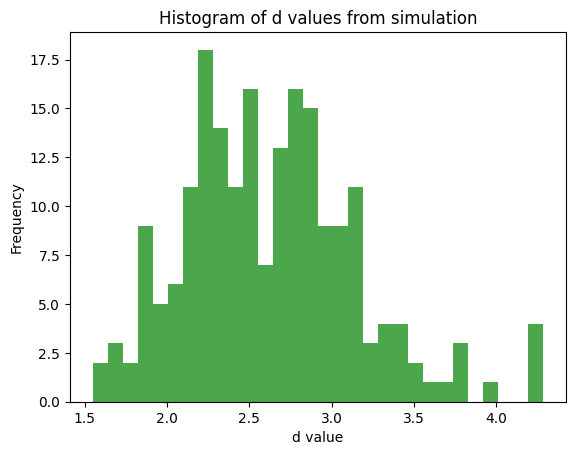

(2.631019733862313, 0.525762737832091)

In [153]:
plt.hist(d_values, bins=30, color='green', alpha=0.7)
plt.xlabel('d value')
plt.ylabel('Frequency')
plt.title('Histogram of d values from simulation')
plt.show()

np.mean(d_values), np.std(d_values)

## Problem 5 c

The histogram resulting from our simulation in 5 b and figure 3.4 both showcase potential pitfalls of interpreting statistical results without considering the underlying distribution. By simulating values from distributions with different means and selecting the largest value from each simulation, we created a distribution of 'winners.' The histogram of these winners is skewed to the right, much like the single observed value of x610 from the book. The frequentist concern of selection bias through selecting the largest observation, a likely outlier, misrepresenting the the estimate of true effect size of the variable. A Bayesian approach in theory isn't affected by this selection bias, given careful consideration of the prior.

## Problem 6

### Perform MLE for Gaussian distribution on `gfr_array`, calculate log-likelihood across `mu` and `sigma` best describing observed data, plot 3D surface

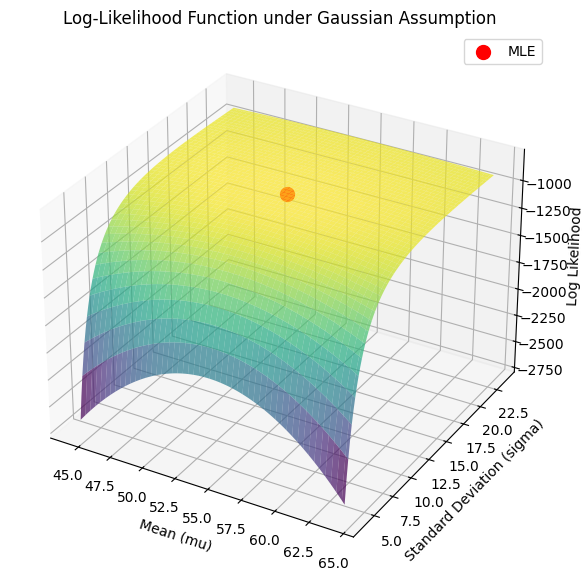

In [154]:
#Setup variables
gfr_array = np.array(gfr)
gfr_mean = np.mean(gfr_array)
gfr_std = np.std(gfr_array, ddof=1)

# Define Gaussian
def log_likelihood(mu, sigma, data):
    return np.sum(norm.logpdf(data, loc=mu, scale=sigma))

# Create grid
mu_values = np.linspace(gfr_mean - 10, gfr_mean + 10, 100)
sigma_values = np.linspace(gfr_std - 10, gfr_std + 10, 100)
mu_grid, sigma_grid = np.meshgrid(mu_values, sigma_values)
# Log likelihood across grid
log_likelihood_values = np.zeros(mu_grid.shape)
for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        log_likelihood_values[i, j] = log_likelihood(mu_grid[i, j], sigma_grid[i, j], gfr_array)

# Create 3d plot and fill it
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Adjust layer transparency and MLE maximum point for clarity
surf = ax.plot_surface(mu_grid, sigma_grid, log_likelihood_values, cmap='viridis', edgecolor='none', alpha=0.7)

mle_log_likelihood = log_likelihood(gfr_mean, gfr_std, gfr_array)
ax.scatter(gfr_mean, gfr_std, mle_log_likelihood + 1, color='r', s=100, label='MLE') 

ax.set_xlabel('Mean (mu)')
ax.set_ylabel('Standard Deviation (sigma)')
ax.set_zlabel('Log Likelihood')
ax.set_title('Log-Likelihood Function under Gaussian Assumption')

ax.legend()
plt.show()

--- Hopefully I interpreted all the problems correctly and formatted everything well enough.